In [54]:
import os

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import colorbar

import tensorflow as tf

from matplotlib import pyplot
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
import tensorflow.keras.backend as K

from functions import *

%matplotlib inline

## Load data

In [2]:
#dataset_path = 'data/segments_normWithinSubjRun_rAI.pkl'
dataset_path = 'data/03a-segments_normWithinSubjRun_rAI.pkl'
with open(dataset_path, 'rb') as f:
    dataset = pkl.load(f)

print("Using dataset: {0}".format(dataset_path))
num_subjs = len(dataset.keys())
print("There are {num_subjs} participants in the dataset".format(num_subjs=num_subjs))

p1 = list(dataset.keys())[0]
p1_data = dataset[p1]['data']
print("Each participant's data is a {0}D array of shape {1}".format(len(p1_data.shape),
                                                                   p1_data.shape))

dataset_df = organize_dataset(dataset)

Using dataset: data/03a-segments_normWithinSubjRun_rAI.pkl
There are 61 participants in the dataset
Each participant's data is a 3D array of shape (14, 745, 39)


## Train-test split

In [3]:
rs = ShuffleSplit(n_splits=50, train_size=.7, random_state=0)
all_participants = dataset_df.participant.unique()

batch_size = 32

for nonTest_idx, test_idx in rs.split(all_participants):
    pass

In [4]:
train_X, train_Y = query_dataset(dataset_df, nonTest_idx)
test_X, test_Y = query_dataset(dataset_df, test_idx)

In [5]:
test_X.shape

(1720, 7, 745)

## Load the trained model

In [6]:
model = tf.keras.models.load_model("models/CustomGRU_rAI.h5")

In [7]:
model.summary()

Model: "sequential_40"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_120 (GRU)                (None, None, 16)          36624     
_________________________________________________________________
gru_121 (GRU)                (None, None, 16)          1632      
_________________________________________________________________
gru_122 (GRU)                (None, 16)                1632      
_________________________________________________________________
dense_40 (Dense)             (None, 1)                 17        
Total params: 39,905
Trainable params: 39,905
Non-trainable params: 0
_________________________________________________________________


## Vanilla Saliency
Source: https://github.com/keisen/tf-keras-vis/blob/master/examples/attentions.ipynb

In [8]:
def model_modifier(m):
    m.layers[-1].activation = tf.keras.activations.linear
    return m


# The `output` variable refer to the output of the model,
# so, in this case, `output` shape is `(3, 1000)` i.e., (samples, classes).
def loss(output):
    # 1 is the imagenet index corresponding to Goldfish, 294 to Bear and 413 to Assault Rifle.
    #print(type(output))
    #print(output)
    return output

In [9]:
%%time
from tensorflow.keras import backend as K
from tf_keras_vis.saliency import Saliency
from tf_keras_vis.utils import normalize

saliency = Saliency(model, clone=False) # model_modifier=model_modifier, 
saliency_map = saliency(loss,test_X, keepdims=True)
saliency_map = normalize(saliency_map)

print('Saliency Map shape:', saliency_map.shape)

#plt.subplot(2,1,1)
#plt.plot(saliency_map.mean(axis=0))
#plt.subplot(2,1,2)
#plt.imshow(saliency_map.mean(axis=0)[None,:]) # vmin=-1, vmax=1) #cmap='gray
#plt.colorbar()

Saliency Map shape: (1720, 7, 745)
CPU times: user 371 ms, sys: 117 ms, total: 488 ms
Wall time: 487 ms


In [21]:
mean_saliency_map = saliency_map.numpy().mean(axis=0)
mean_saliency_map.shape

(7, 745)

## Rendering Salience to Brain Template

In [43]:
import nilearn as nil
from nilearn.masking import apply_mask, unmask
from nilearn.plotting import plot_glass_brain, plot_epi, plot_matrix
from nilearn import plotting

In [28]:
## Load right ventro-anterior insula mask 
mask= nil.image.load_img('data/masks/00a-Schaefer2018_300Parcels_17Networks_order_afniMNI152_2mm_GM.nii.gz')
rvAI = np.zeros_like(mask.get_fdata())
rvAI[np.logical_or(mask.get_fdata() == 230,mask.get_fdata() == 231)] = 1
rvAI_img = nil.image.new_img_like(mask,rvAI)

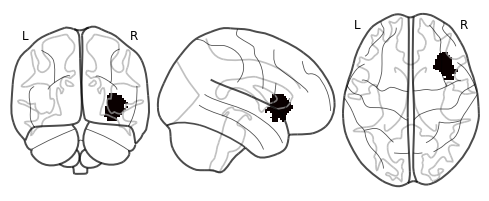

In [32]:
plot_glass_brain(rvAI_img)

In [41]:
vols = []
for i in range(mean_saliency_map.shape[0]):
    vols.append(unmask(mean_saliency_map[i,:],rvAI_img))
    
saliency_brainmap = nil.image.concat_imgs(vols,ensure_ndim=4)

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



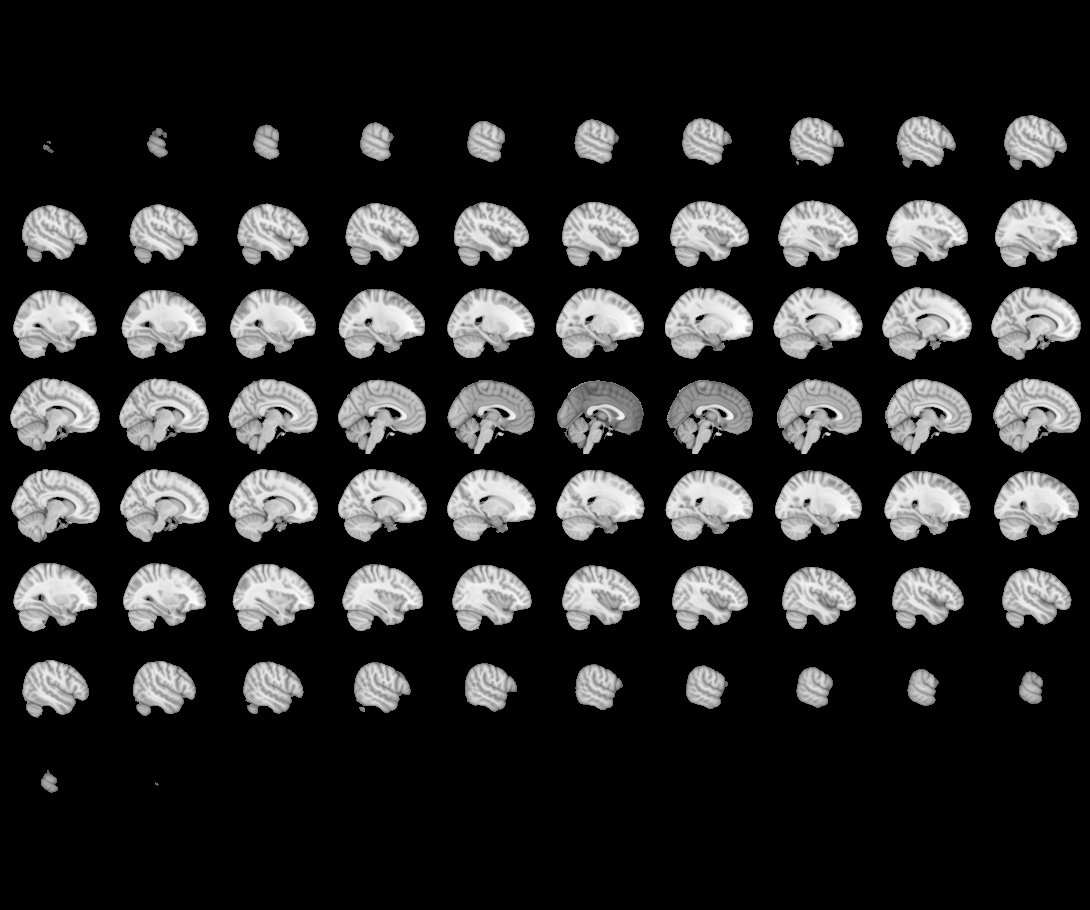
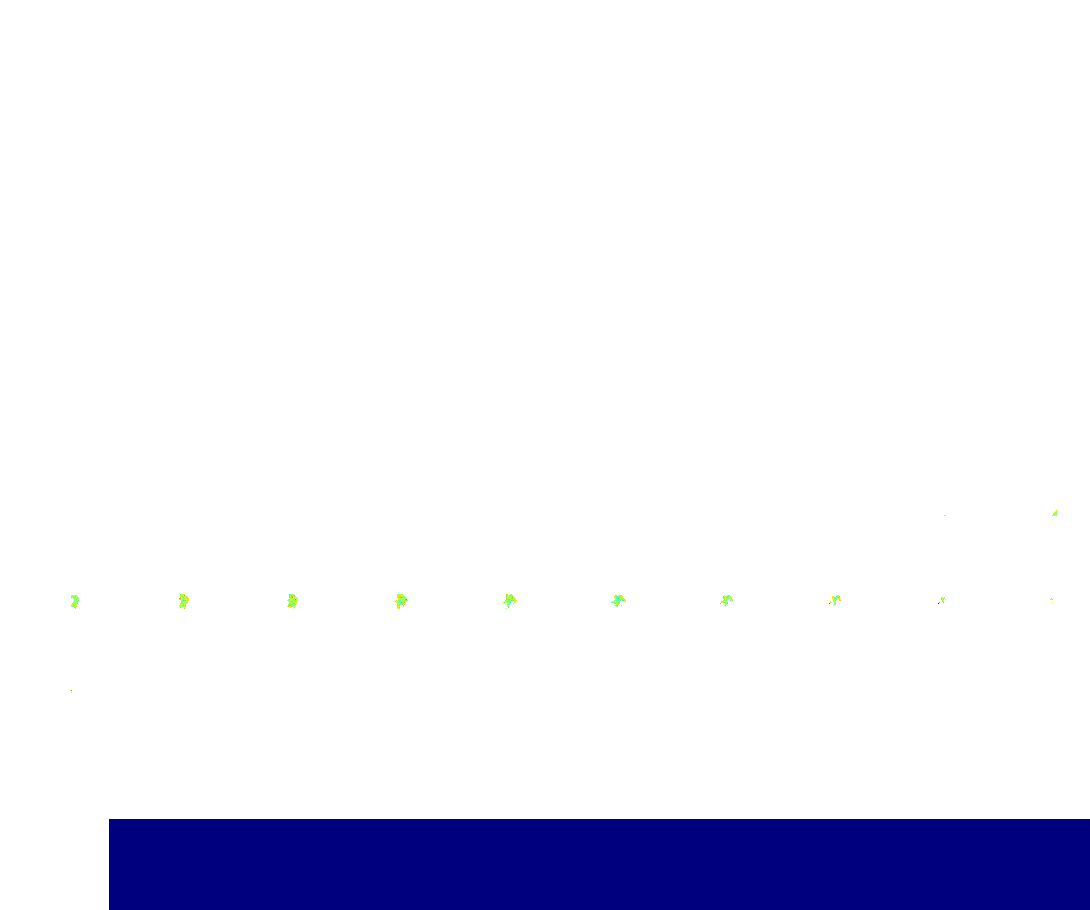

In [80]:
plotting.view_img(vols[0],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR1',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



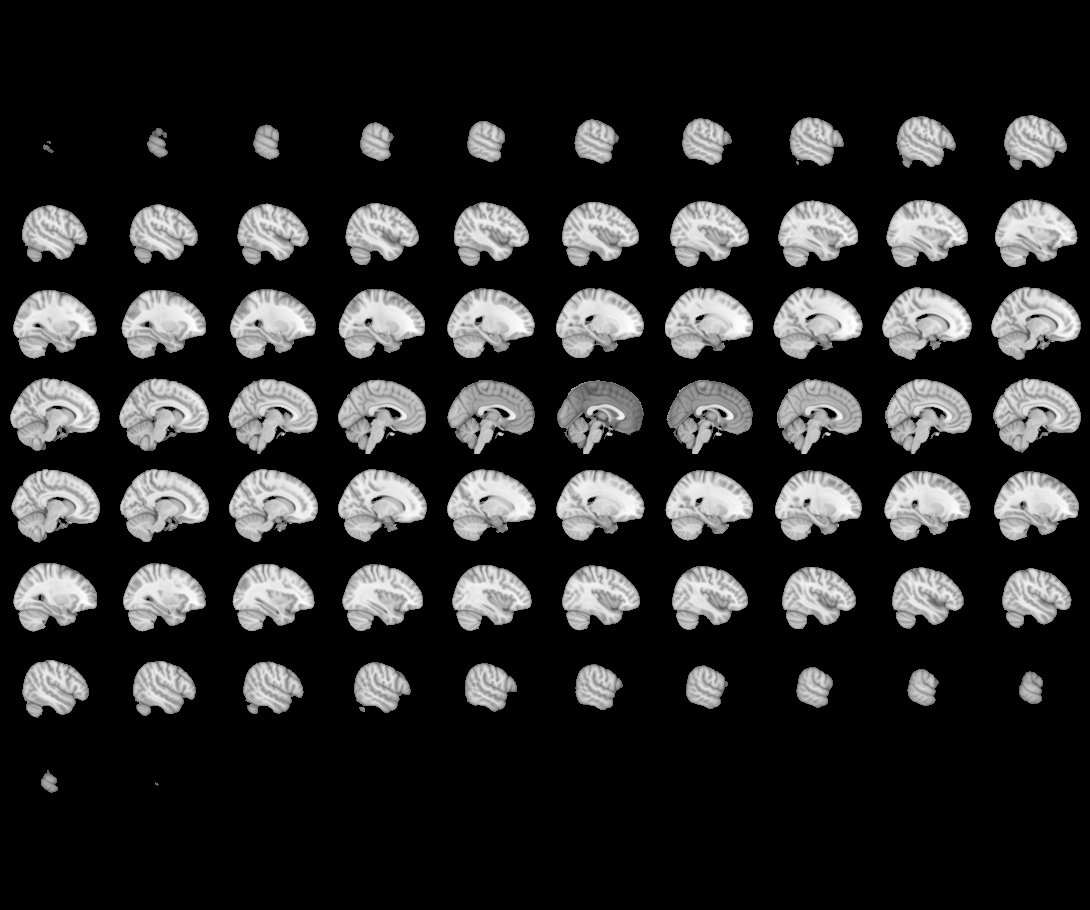
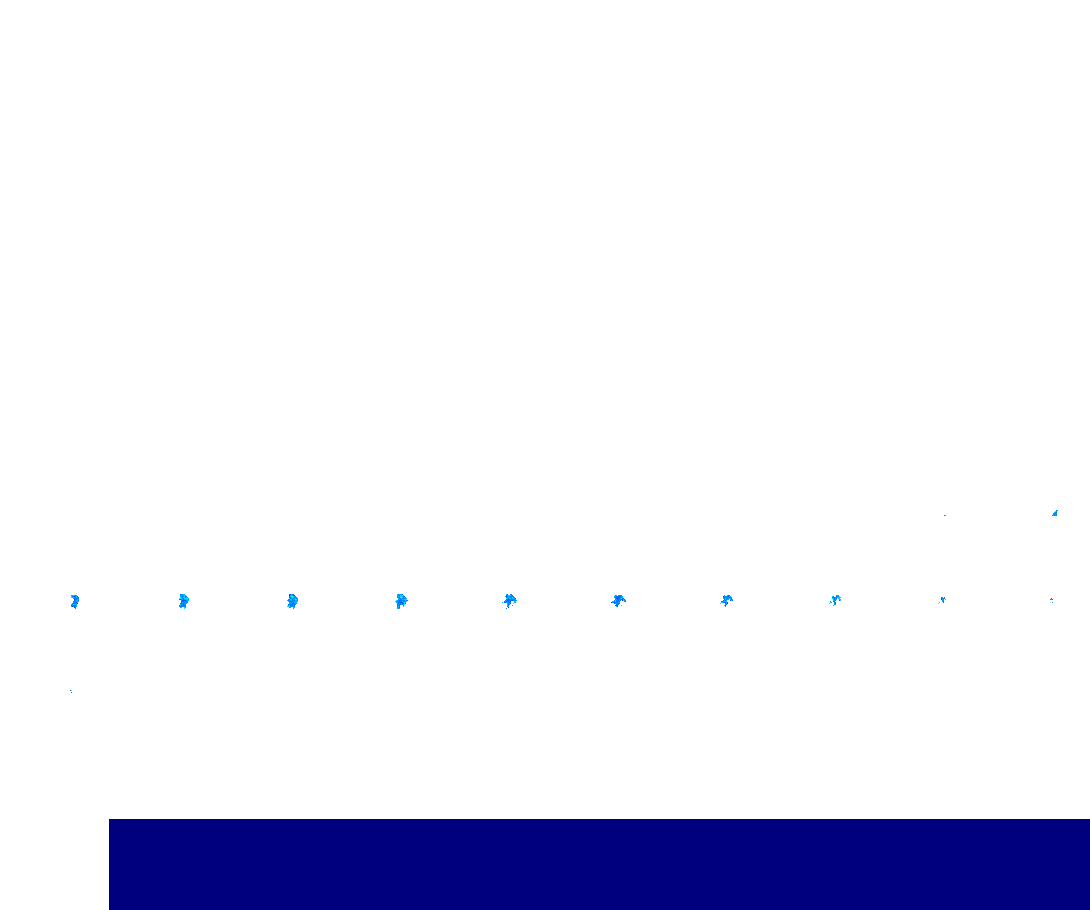

In [81]:
plotting.view_img(vols[1],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR2',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



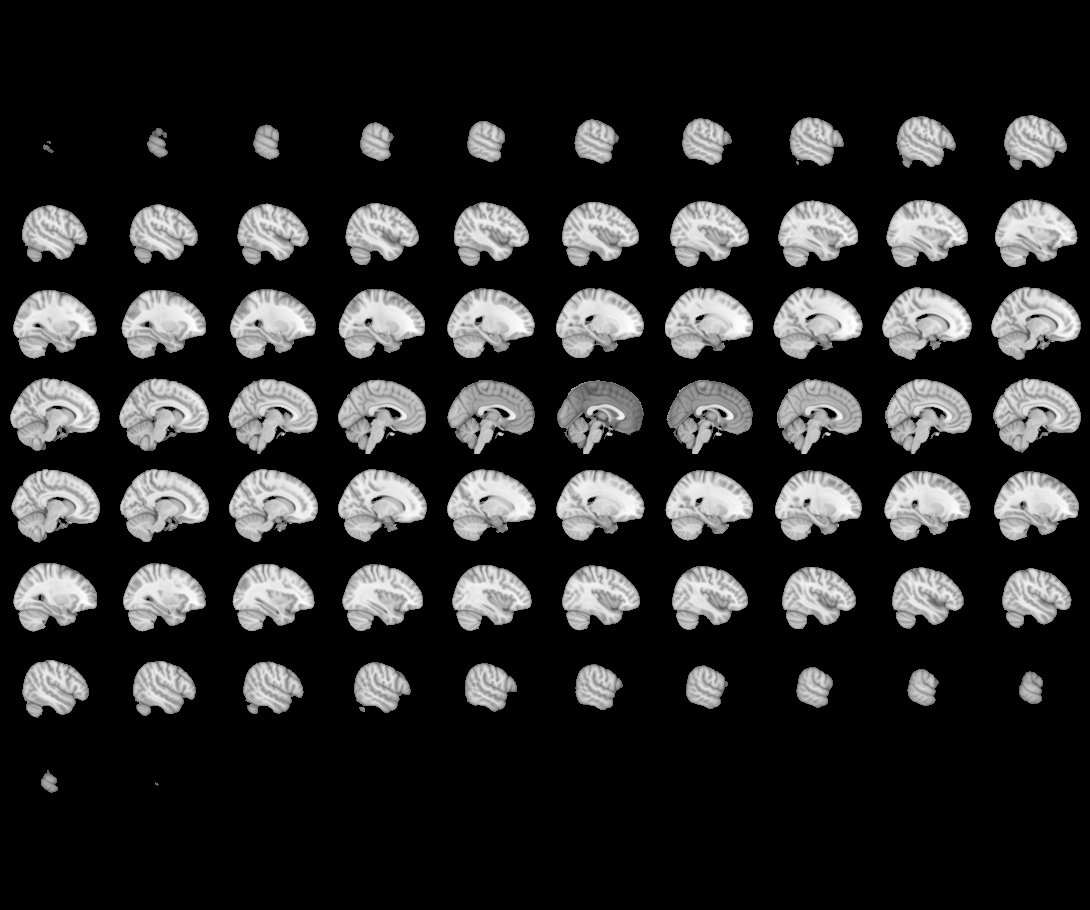
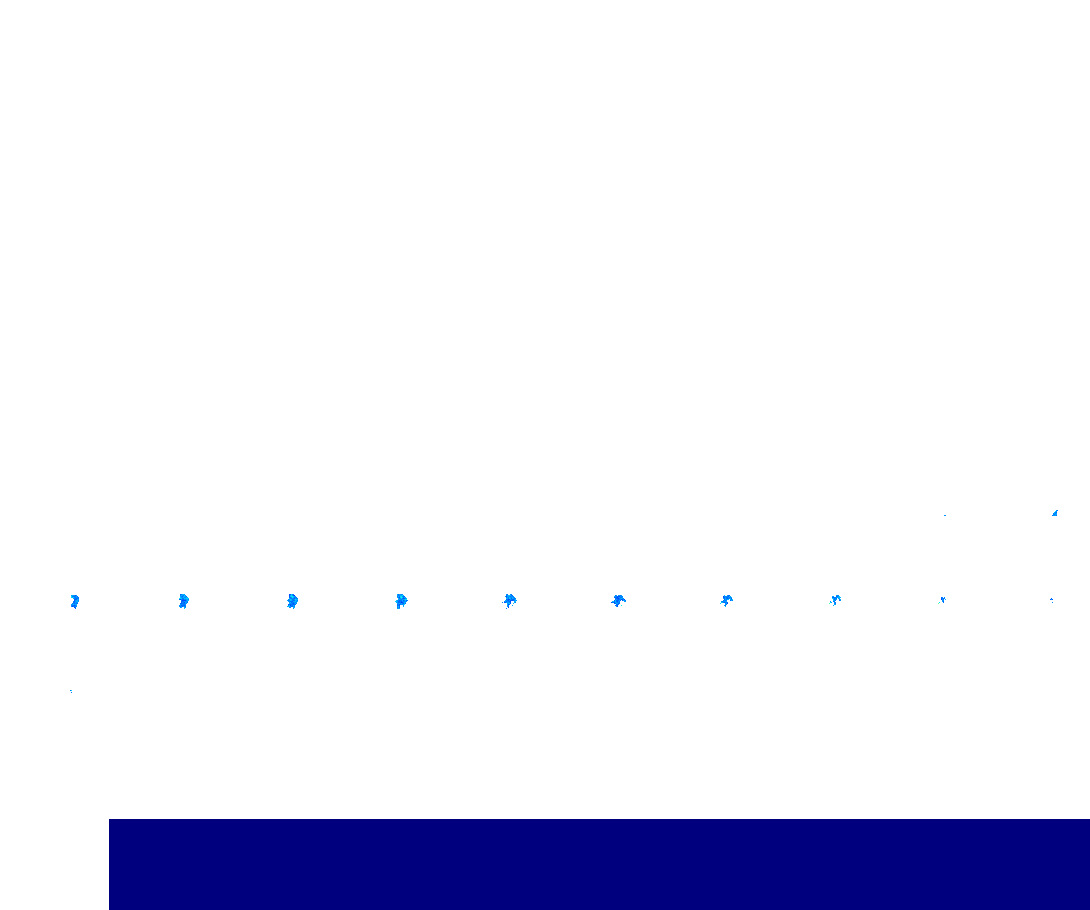

In [82]:
plotting.view_img(vols[2],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR3',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



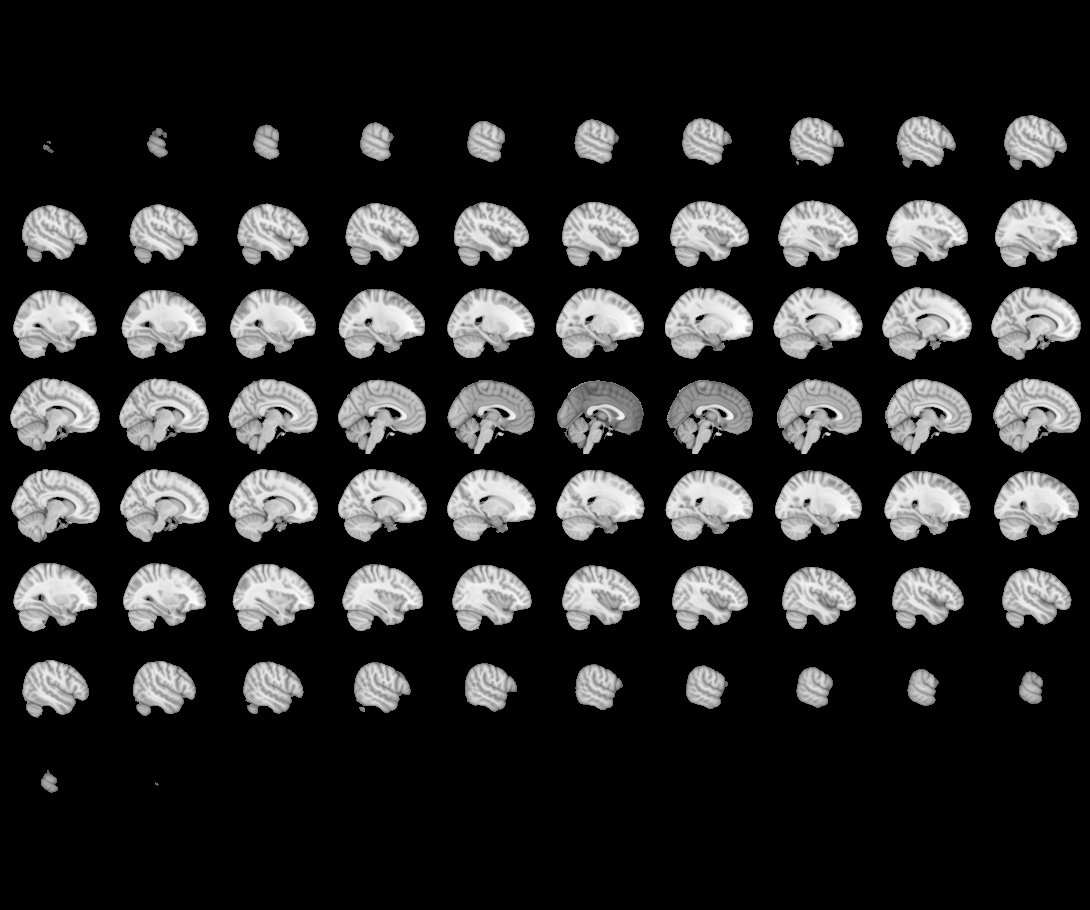
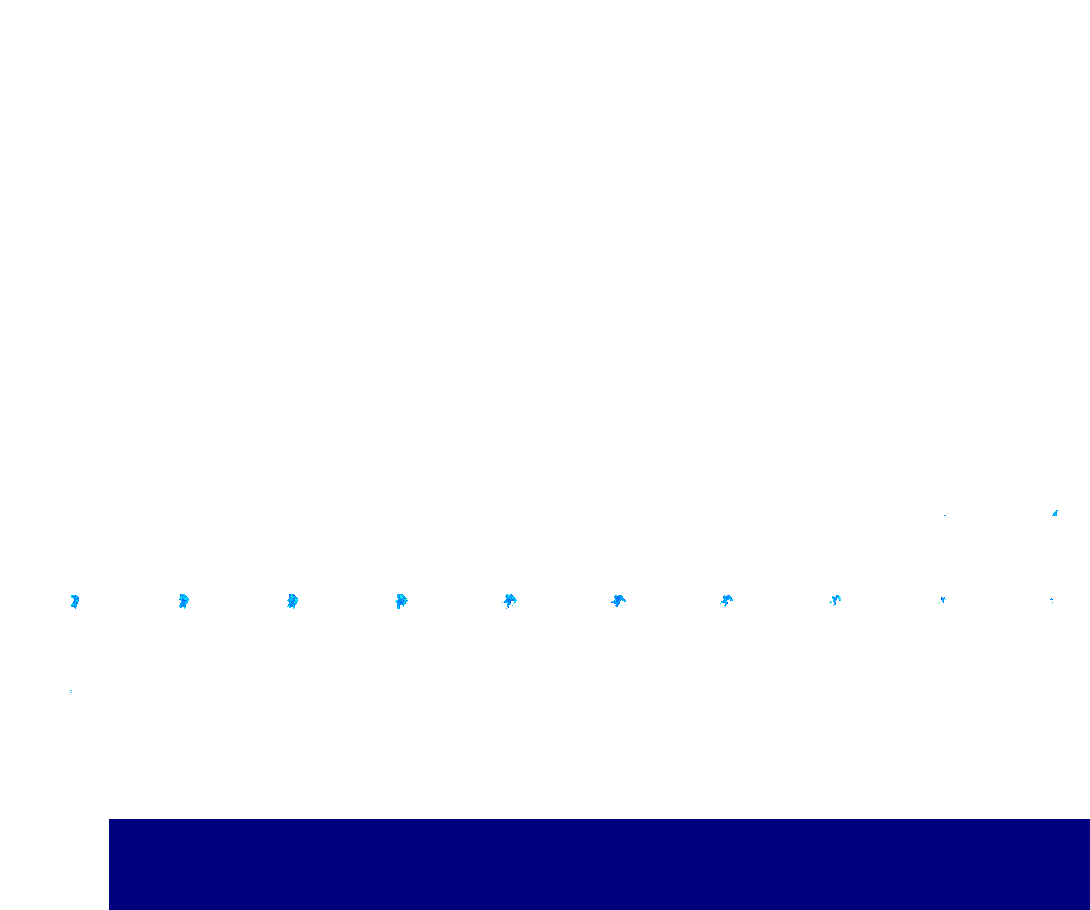

In [83]:
plotting.view_img(vols[3],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR4',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



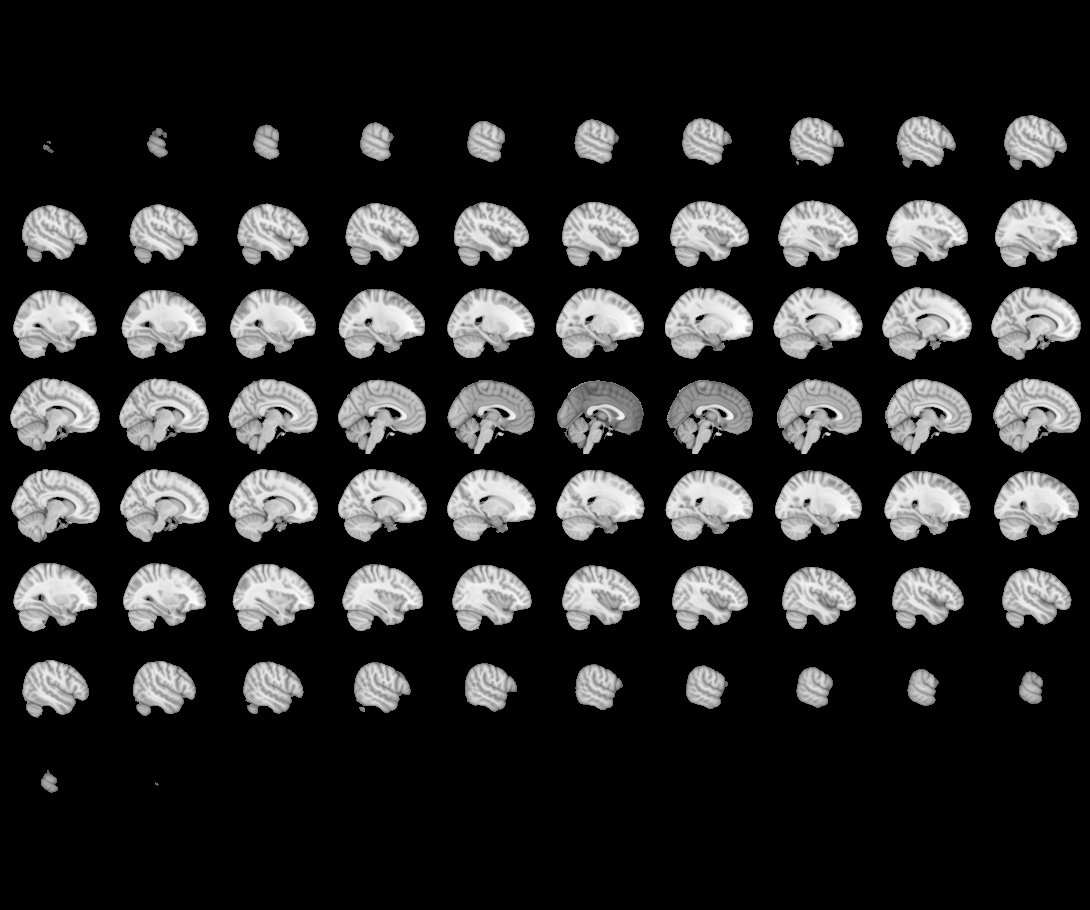
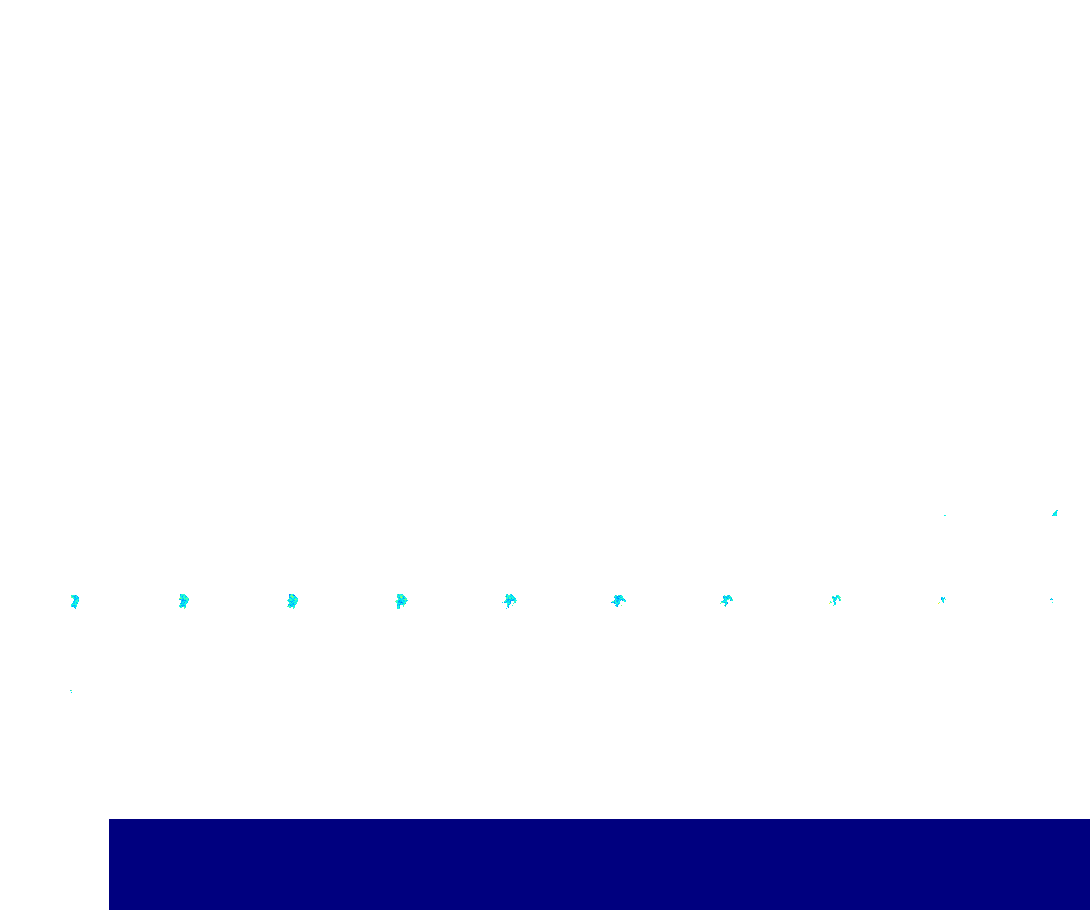

In [84]:
plotting.view_img(vols[4],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR5',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



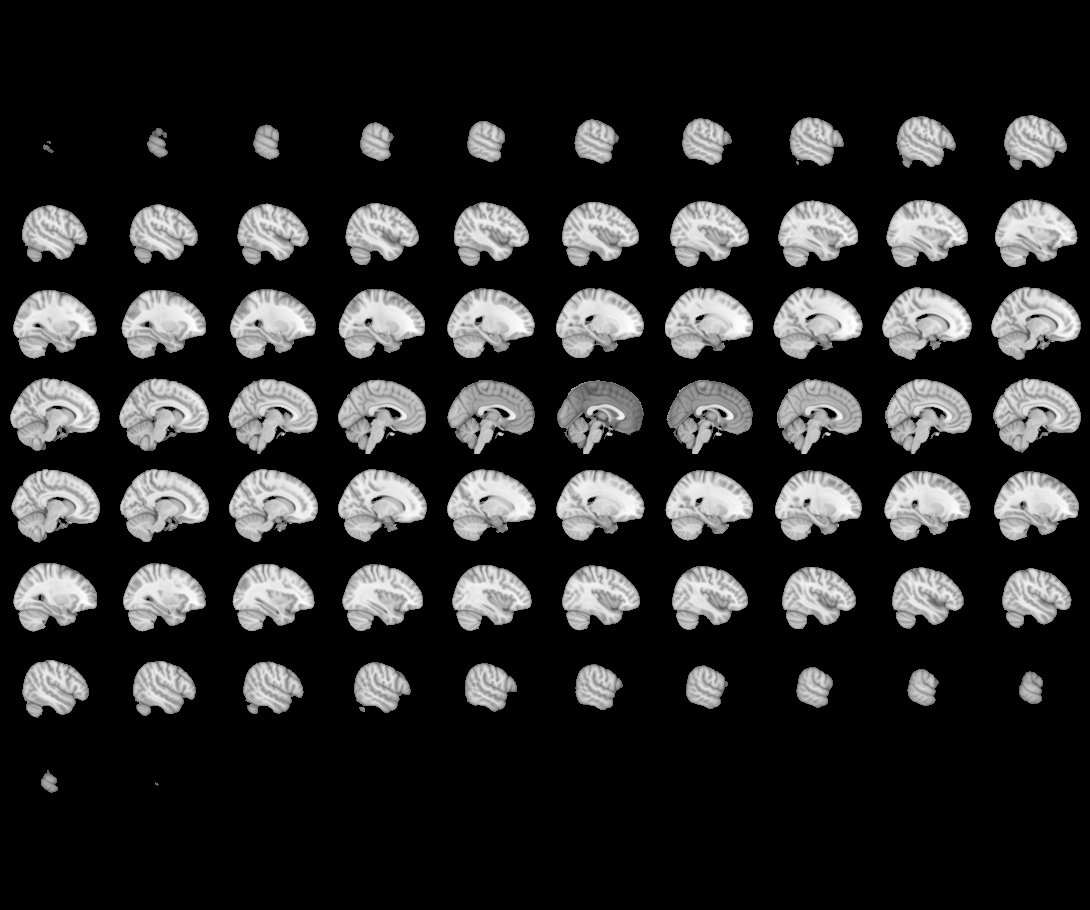
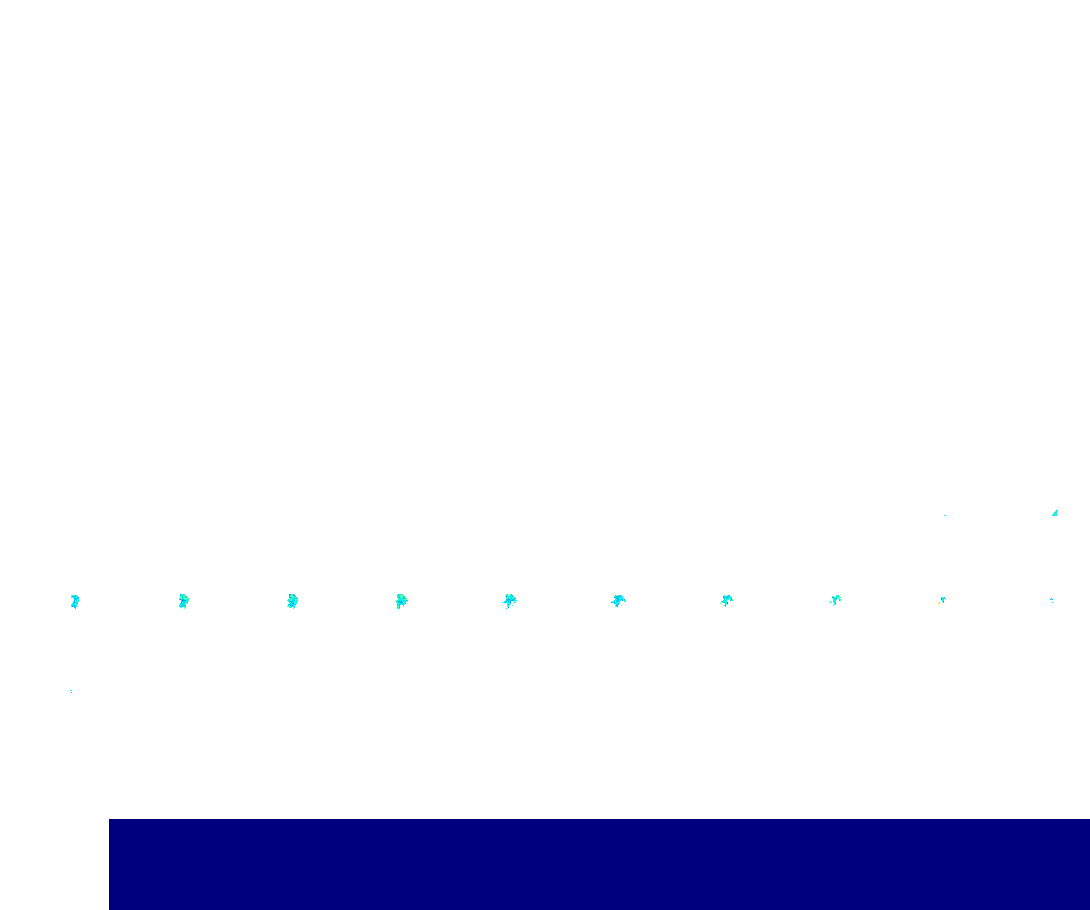

In [85]:
plotting.view_img(vols[5],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR6',cmap='jet')

/home/climbach/approach-retreat/tensorflow/local/lib/python3.6/site-packages/nilearn/reporting/html_document.py:60: UserWarning: It seems you have created more than 10 nilearn views. As each view uses dozens of megabytes of RAM, you might want to delete some of them.
  MAX_IMG_VIEWS_BEFORE_WARNING))



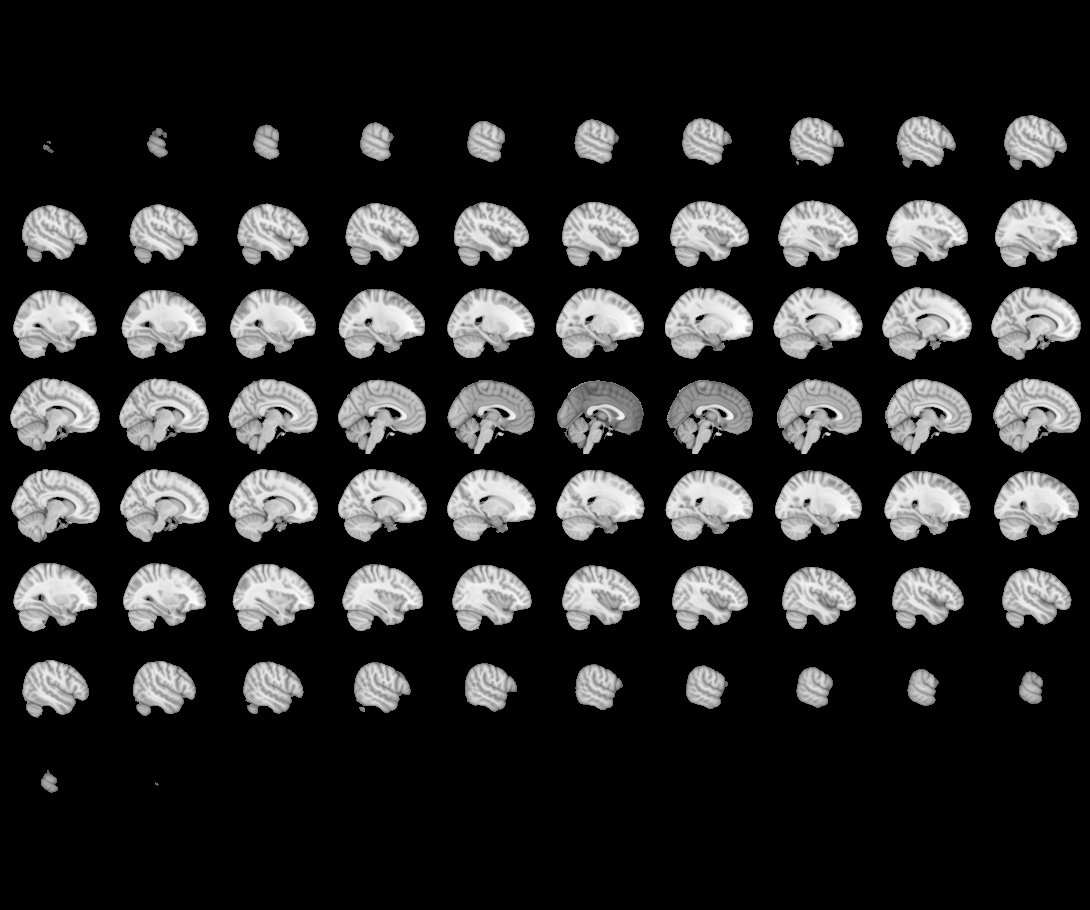
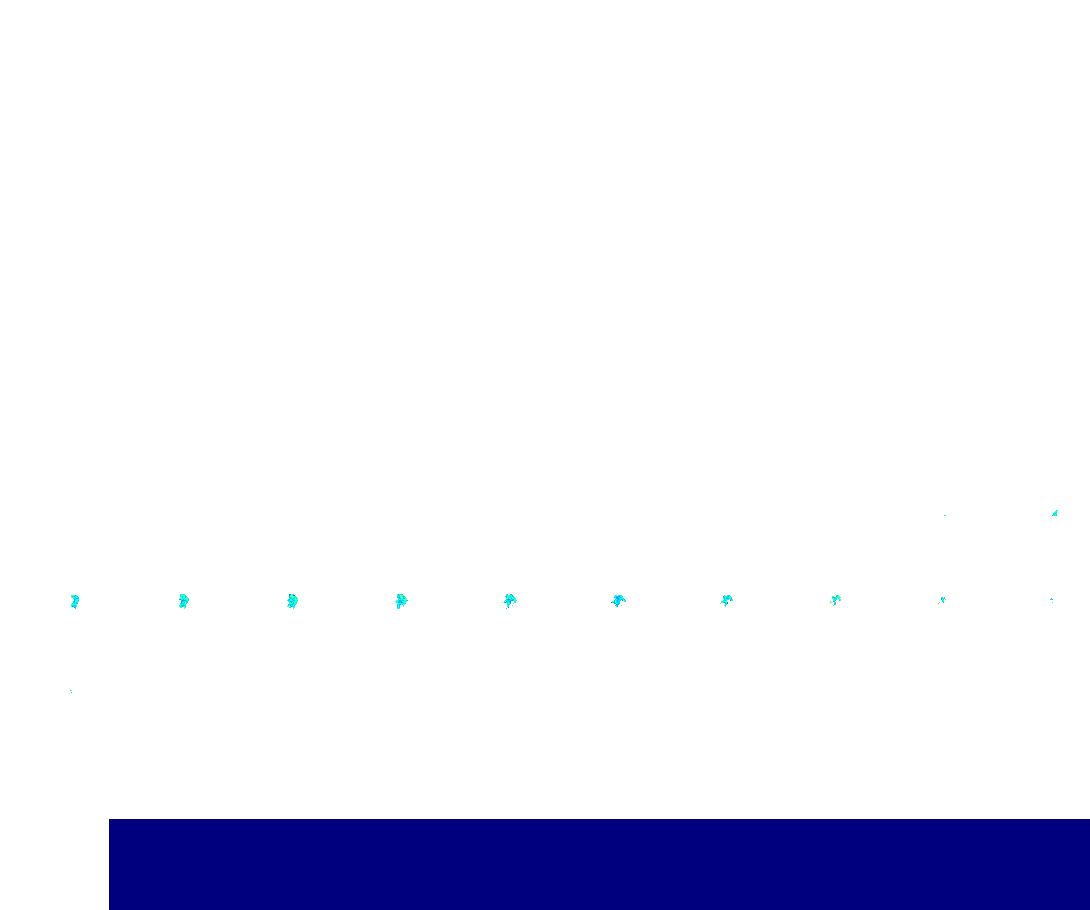

In [90]:
plotting.view_img(vols[6],dim=0, vmax=mean_saliency_map.max(),
                  draw_cross=False,
                  symmetric_cmap=False, 
                  title='TR7',cmap='jet')

In [89]:
saliency_brainmap.to_filename('results/saliency_bm_rAI.nii.gz')